In [9]:
import os
import warnings

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

warnings.filterwarnings("ignore")

print("TensorFlow versiyonu:", tf.__version__)


TensorFlow versiyonu: 2.19.0


In [10]:
# Görüntü boyutları ve batch size
img_height = 224
img_width = 224
batch_size = 32

# Veri seti ana klasörü
dataset_path = "panel_data"  

In [11]:


# Sınıf isimleri: 0 = Kirli, 1 = Temiz
class_names = ["Kirli", "Temiz"]
print("Sınıflar:", class_names)

# Train / Validation bölme
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    label_mode="binary",          # 0.0 / 1.0 olarak gelecek
    class_names=class_names,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    label_mode="binary",
    class_names=class_names,
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

print("Train batch sayısı:", len(train_ds))
print("Validation batch sayısı:", len(val_ds))


Sınıflar: ['Kirli', 'Temiz']
Found 3632 files belonging to 2 classes.
Using 2543 files for training.
Found 3632 files belonging to 2 classes.
Using 1089 files for validation.
Train batch sayısı: 80
Validation batch sayısı: 35


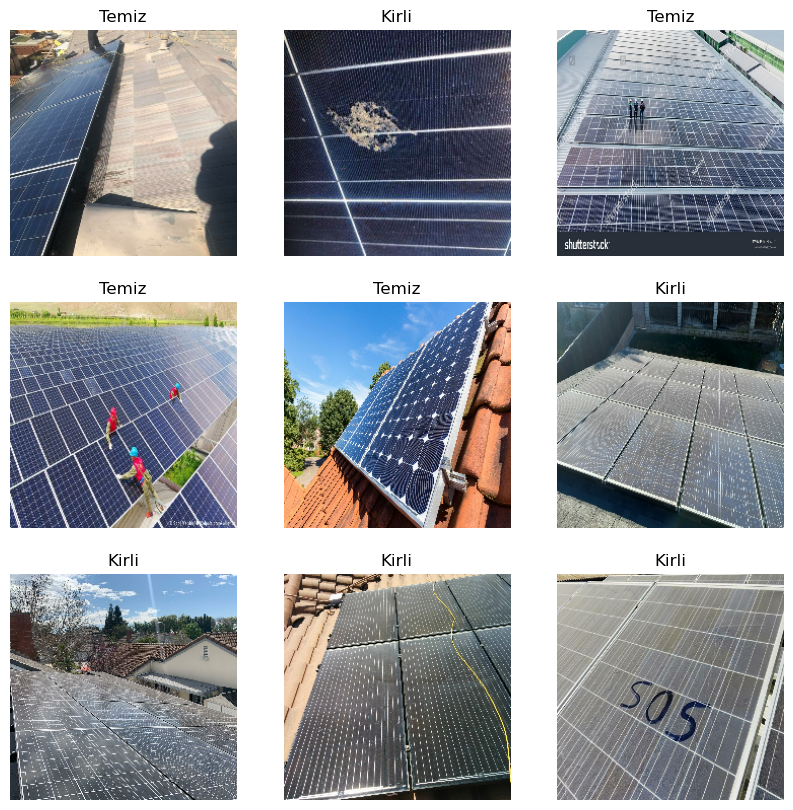

In [12]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = int(labels[i].numpy())   # 0 veya 1
        plt.title(class_names[label])
        plt.axis("off")

plt.show()


In [13]:
# Shallow CNN base model 

model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255),

    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(1, activation="sigmoid"),
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,561 (49.36 MB)

 Trainable params: 12,938,561 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model derlendi.")


Model derlendi.


In [15]:
epochs = 30

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-2,
    patience=3,
    verbose=1,
    restore_best_weights=True,
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping],
)


Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 353ms/step - accuracy: 0.5522 - loss: 0.9054 - val_accuracy: 1.0000 - val_loss: 0.4012
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 28s 341ms/step - accuracy: 0.6167 - loss: 0.6496 - val_accuracy: 0.6171 - val_loss: 0.6074
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 332ms/step - accuracy: 0.7323 - loss: 0.5482 - val_accuracy: 0.8843 - val_loss: 0.2989
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 340ms/step - accuracy: 0.7378 - loss: 0.5268 - val_accuracy: 0.7006 - val_loss: 0.5818
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 338ms/step - accuracy: 0.7803 - loss: 0.4600 - val_accuracy: 0.7971 - val_loss: 0.4161
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 338ms/step - accuracy: 0.8359 - loss: 0.3650 - val_accuracy: 0.7254 - val_loss: 0.6467
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


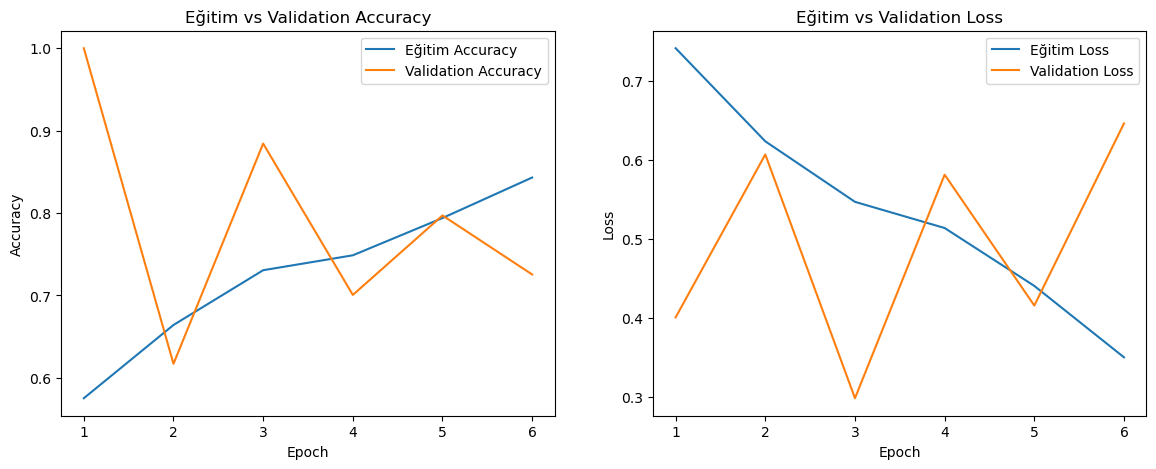

In [16]:
history_dict = history.history

train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs_range = range(1, len(train_acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Eğitim Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Eğitim vs Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Eğitim Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eğitim vs Validation Loss")
plt.legend()

plt.show()


35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.8600 - loss: 0.3202
Validation Loss : 0.2989
Validation Acc. : 0.8843


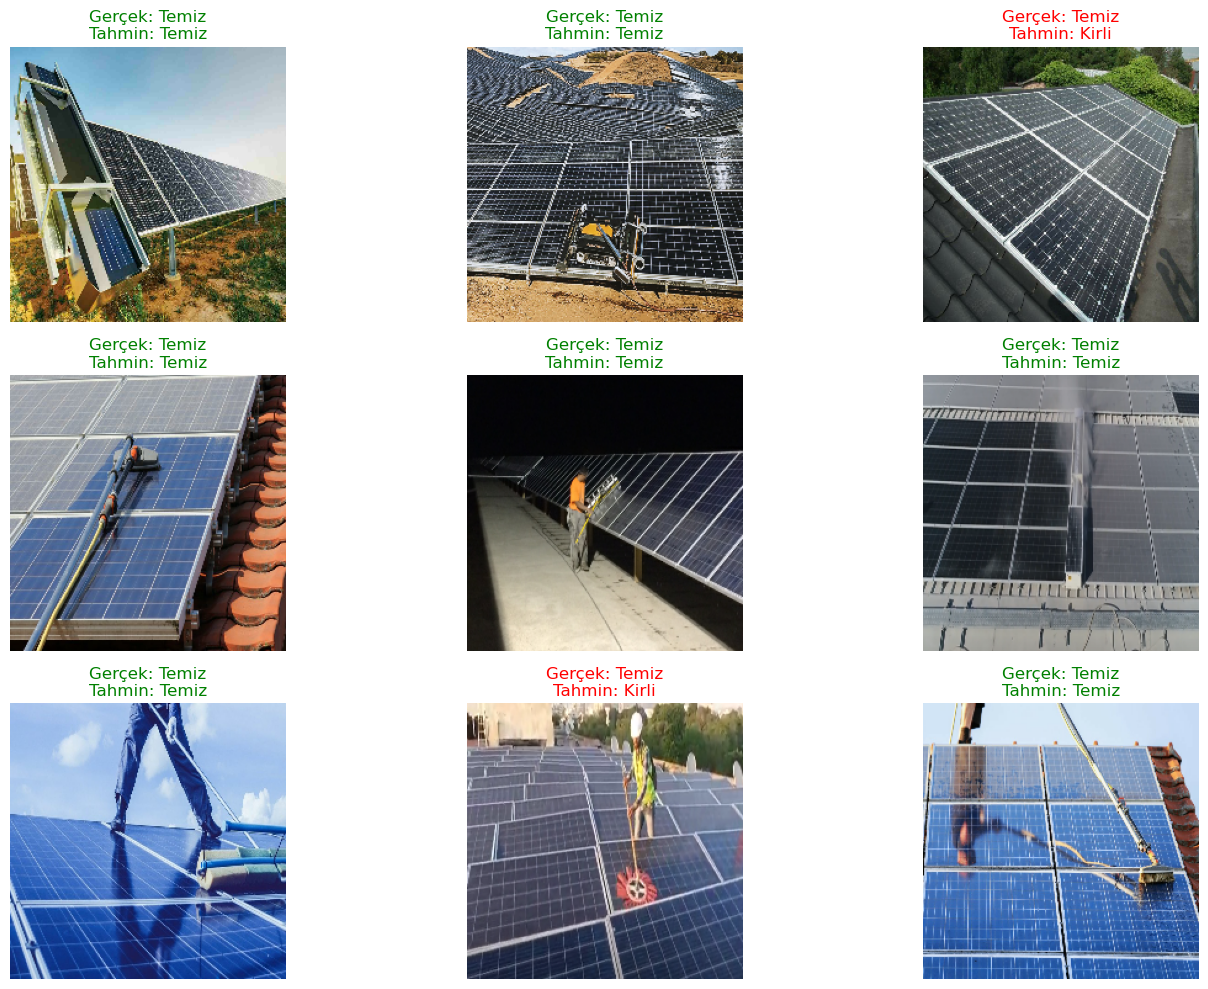

In [17]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss : {loss:.4f}")
print(f"Validation Acc. : {accuracy:.4f}")

# Bazı örnek görüntülerin tahminlerini görelim
import math

plt.figure(figsize=(15, 10))

for images, labels in val_ds.take(1):
    preds = model.predict(images, verbose=0).ravel()      # (batch_size,)
    pred_labels = (preds >= 0.5).astype(int)              # 0/1

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        true_label = int(labels[i].numpy())
        predicted_label = int(pred_labels[i])

        true_name = class_names[true_label]
        pred_name = class_names[predicted_label]

        color = "green" if true_label == predicted_label else "red"
        plt.title(f"Gerçek: {true_name}\nTahmin: {pred_name}", color=color)
        plt.axis("off")

plt.tight_layout()
plt.show()


In [18]:
y_true = []
y_pred = []

for images, labels in val_ds:
    # labels: (batch_size, 1) binary (0.0 veya 1.0)
    labels_np = labels.numpy().ravel()                   # (batch_size,)

    preds = model.predict(images, verbose=0).ravel()     # (batch_size,)
    pred_labels = (preds >= 0.5).astype(int)            # 0/1 sınıf etiketi

    y_true.extend(labels_np)
    y_pred.extend(pred_labels)

y_true = np.array(y_true).astype(int)
y_pred = np.array(y_pred).astype(int)

# --- Sınıflandırma Metrikleri ---
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# --- Regresyon tipi metrikler (etiketler 0/1 kabul edilerek) ---
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("\nEk (regresyon tipi) metrikler:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R2   : {r2:.4f}")


Confusion Matrix:
 [[  0   0]
 [126 963]]

Classification Report:

              precision    recall  f1-score   support

       Kirli       0.00      0.00      0.00         0
       Temiz       1.00      0.88      0.94      1089

    accuracy                           0.88      1089
   macro avg       0.50      0.44      0.47      1089
weighted avg       1.00      0.88      0.94      1089


Ek (regresyon tipi) metrikler:
MAE  : 0.1157
MSE  : 0.1157
RMSE : 0.3402
R2   : 0.0000


In [19]:
model_save_path = "FET312_22040301102_PATtechs_model_2.keras"
model.save(model_save_path)
print("Model kaydedildi:", model_save_path)


Model kaydedildi: FET312_22040301102_PATtechs_model_2.keras


In [20]:
# Keras modelini TFLite formatına dönüştürme

loaded_model = tf.keras.models.load_model("FET312_22040301102_PATtechs_model_2.keras")

converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

tflite_path = "FET312_22040301102_PATtechs_model_2"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print("TFLite model kaydedildi:", tflite_path)


INFO:tensorflow:Assets written to: C:\Temp\tmpa7m06u0p\assets


INFO:tensorflow:Assets written to: C:\Temp\tmpa7m06u0p\assets


Saved artifact at 'C:\Temp\tmpa7m06u0p'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2468181072656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2468181561712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2468181573328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2468181568576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2468181572448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2468182199456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2468182211424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2468182209664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2468182208256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2468182317136: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite model kaydedildi: FET312_

In [21]:
import cv2
import numpy as np
import tensorflow as tf
import os
from datetime import datetime

# === MODELİ YÜKLE ===
model = tf.keras.models.load_model("cnn_base_model_panel_dropout3Conv.keras")
class_names = ["Kirli", "Temiz"]

# === KAYIT KLASÖRÜ ===
save_dir = "model_ile_kaydedilen_paneller_CNN"
os.makedirs(save_dir, exist_ok=True)

# === KAMERA AÇ ===
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Kamera açılamadı!")
    raise SystemExit

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Görüntü alınamadı!")
            break

        # Görüntüyü modele göre hazırla
        img = cv2.resize(frame, (img_width, img_height)).astype("float32")
        img_batch = np.expand_dims(img, axis=0)  # (1, H, W, 3)

        # Tahmin
        preds = model.predict(img_batch, verbose=0).ravel()
        prob = float(preds[0])
        class_index = int(prob >= 0.5)       # 0: Kirli, 1: Temiz
        predicted_label = class_names[class_index]

        # Ekrana yazı bastır
        label_text = f"{predicted_label} ({prob:.2f})"
        output_frame = frame.copy()
        cv2.putText(
            output_frame,
            label_text,
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 0),
            2
        )

        cv2.imshow("Gunes Paneli Tespiti (Dropout CNN Base Model)", output_frame)

        # Güven çok yüksekse resmi kaydet
        if prob > 0.99 or prob < 0.01:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"{predicted_label}_{timestamp}.jpg"
            save_path = os.path.join(save_dir, filename)
            cv2.imwrite(save_path, output_frame)
            print(f"✅ Kaydedildi: {save_path}")

        # 'e' tuşuna basınca çık
        if cv2.waitKey(1) & 0xFF == ord('e'):
            print("Çıkış yapılıyor...")
            break

finally:
    cap.release()
    cv2.destroyAllWindows()
    print("Kamera kapatıldı, pencereler kapatıldı.")


ValueError: File not found: filepath=cnn_base_model_panel_dropout3Conv.keras. Please ensure the file is an accessible `.keras` zip file.